# Apollo 3 ADC Capture Analyzer

This notebooks communicates to Apollo3 EVB running the PCM capture demo. 

The results are read back through the UART.

Time domain samples and FFT are plotted, and THD+N is calculated.

In [1]:
# Need the following packages to be installed. Uncomment and execute as needed.
#! pip install PySerial
#! pip install numpy
#! pip install pyplot
#! pip install matplotlib
#! pip install scipy

In [2]:
import serial
import numpy as np
import matplotlib.pyplot as plt

%matplotlib notebook

from scipy import signal
import matplotlib.pyplot as plt

from analyzer import THDN, freqEstimator, plotFFT

## Open Serial Port  

Run this cell once (per kernel)

In [63]:
port = '/dev/tty.usbmodem0004830865351'

serialPort = serial.Serial(port = port, baudrate=115200,
                           bytesize=8, timeout=2, stopbits=serial.STOPBITS_ONE)

## Get PCM samples from Apollo 3

In [74]:
serialString = ""     # Used to hold data coming over UART
line = ""             # Used to hold decoded Ascii

captureEnabled=False  # Set True when first sample comes in, and False after last sample 

samples = np.array([])

while(1):

    # Wait until there is data waiting in the serial buffer
    if(serialPort.in_waiting > 0):

        # Read data out of the buffer until a carraige return / new line is found
        serialString = serialPort.readline()

        # Decode Ascii
        line = serialString.decode('Ascii')
        
        # remove newlines
        line = line.rstrip()
        

        if 'Send out ALL AMic data!' in line:
            captureEnabled = False;
            break;
        
        if captureEnabled:
            samples = np.append(samples, np.array(line.split(' ')).astype(np.int))
            
        else:
            # Print the contents of the serial data (when capture is disabled)
            print(line)
            
        if 'Analog Mic data as following:' in line:
            captureEnabled = True;
  

        # Tell the device connected over the serial port that we recevied the data!
        # The b at the beginning is used to indicate bytes!
        #serialPort.write(b"Thank you for sending data \r\n")

print('\n############################################\n')
print('Samples captured (N = %d)' % (len(samples)))
print('Min = %d' % np.min(samples))
print('Max = %d' % np.max(samples))
samples 


All data were sended out...



Waiting 2 seconds to evaluate AMic and DMic...
Start to get audio data...
Get Analog Mic data 64000 bytes!
Get PDM audio data 0 bytes!
Audio data collection ended....Analog Mic data as following:

############################################

Samples captured (N = 16000)
Min = 0
Max = 15772


array([1390.,   40.,  138., ..., 1963., 4411., 7381.])

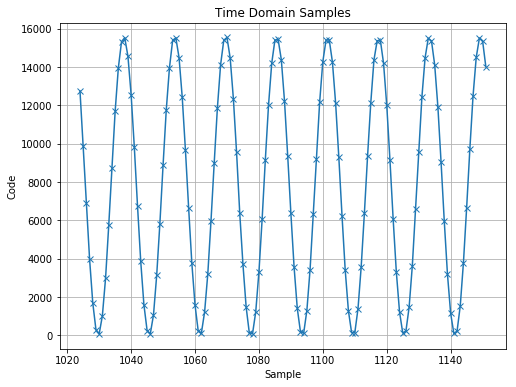

In [75]:
Nskip = 1024
Nsamp = 128
fs = 16000

plt.figure(figsize=(8,6))
plt.plot(np.arange(Nskip, Nskip+Nsamp), samples[Nskip:Nskip+Nsamp], 'x-')
plt.title('Time Domain Samples')
plt.xlabel('Sample')
plt.ylabel('Code')
plt.grid(True)
plt.show()

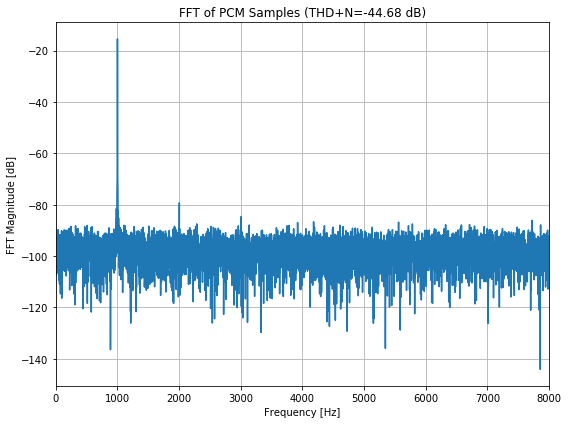

In [76]:
plt.figure(figsize=(8,6))
plotFFT(samples/2**13, fs, log=False)
plt.grid(True)
plt.xlabel('Frequency [Hz]')
plt.ylabel('FFT Magnitude [dB]')
plt.title('FFT of PCM Samples (THD+N=%.2f dB)' % THDN(samples))
plt.xlim([0, fs/2])
plt.tight_layout()

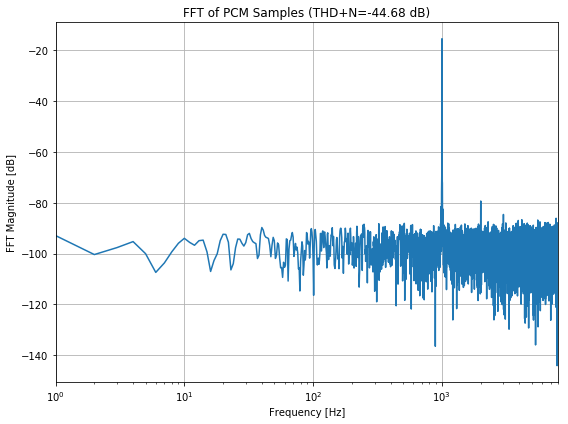

In [77]:
plt.figure(figsize=(8,6))
plotFFT(samples/2**13, fs, log=True)
plt.grid(True)
plt.xlabel('Frequency [Hz]')
plt.ylabel('FFT Magnitude [dB]')
plt.title('FFT of PCM Samples (THD+N=%.2f dB)' % THDN(samples))
plt.xlim([1, fs/2])
plt.tight_layout()

In [78]:
fs = 16000  # Sample frequency (Hz)
    
print('    Number of samples = %d' % (len(samples)))
print('Fundamental Frequency = %.2f Hz' % (freqEstimator(samples, fs)))
print('                THD+N = %.2f dB' % (THDN(samples)))
print('                 ENOB = %.2f bits' % ((THDN(samples)*(-1)-1.76)/6.02))

    Number of samples = 16000
Fundamental Frequency = 1003.00 Hz
                THD+N = -44.68 dB
                 ENOB = 7.13 bits
